# import file

In [ ]:
from google.colab import files
import os

print("upload'kaggle.json':")
uploaded = files.upload()

if 'kaggle.json' in uploaded:
    print("kaggle.json berhasil di-upload.")
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("upload gagal")

upload'kaggle.json':


Saving kaggle.json to kaggle.json
kaggle.json berhasil di-upload.


# download & ekstrak dataset

In [ ]:
!kaggle datasets download -d tommyngx/inbreast2012
print("unzip dataset...")
!unzip -q inbreast2012.zip

print("selesai, file yang diekstrak:")
!ls -lh

Dataset URL: https://www.kaggle.com/datasets/tommyngx/inbreast2012
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 99% 1.92G/1.93G [00:13<00:00, 254MB/s]
100% 1.93G/1.93G [00:13<00:00, 150MB/s]
unzip dataset...
selesai, file yang diekstrak:
total 2.0G
-rw-r--r-- 1 root root 2.0G Oct  7  2022  inbreast2012.zip
drwxr-xr-x 7 root root 4.0K Nov 13 12:34 'INbreast Release 1.0'
drwxr-xr-x 1 root root 4.0K Nov 11 14:29  sample_data


# import library

In [ ]:
# Import library untuk mengunggah file di Colab
from google.colab import files
import os

# Library utama untuk deep learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Conv2D
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

# Library untuk manipulasi data dan numerik
import pandas as pd
import numpy as np

# Library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk pemrosesan gambar dan sistem file
import cv2
import glob # Untuk mencari file
!pip install pydicom
import pydicom
import scipy

# Library dari Scikit-learn untuk evaluasi model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GroupKFold

from skimage import filters
from skimage.color import rgb2gray

print("seluruh library yang dibutuhkan telah berhasil di import")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.9 MB/s eta 0:00:00
seluruh library yang dibutuhkan telah berhasil di import


# prepocessing

In [ ]:
# --- A. FUNGSI HELPER (Segmentasi & Cropping) ---
def get_masks_and_sizes_of_connected_components(img_mask):
    """
    Menemukan semua 'pulau' (connected components) dalam masker biner.
    """
    mask, num_labels = scipy.ndimage.label(img_mask)
    mask_pixels_dict = {}
    for i in range(1, num_labels + 1):
        this_mask = (mask == i)
        if img_mask[this_mask].any():
            mask_pixels_dict[i] = np.sum(this_mask)
    return mask, mask_pixels_dict

def get_mask_of_largest_connected_component(img_mask):
    """
    Mengembalikan masker biner dari 'pulau' (objek) terbesar.
    """
    mask, mask_pixels_dict = get_masks_and_sizes_of_connected_components(img_mask)
    if not mask_pixels_dict:
        return img_mask
    largest_mask_index = pd.Series(mask_pixels_dict).idxmax()
    largest_mask = (mask == largest_mask_index)
    return largest_mask

def segment_and_crop(img):
    """
    Pipeline lengkap untuk memproses dan memotong gambar payudara.
    Input adalah gambar grayscale (float32).
    """
    # 1. Thresholding (Isodata) untuk membuat gambar biner
    threshold = filters.threshold_isodata(img)
    bin_img = (img > threshold)

    # 2. Operasi Morfologi (Erosion) untuk membersihkan noise
    kernel = np.ones((5, 5), np.uint8)
    bin_img = bin_img.astype('uint8')
    bin_img = cv2.erode(bin_img, kernel, iterations=2)

    # 3. Temukan objek terbesar (payudara)
    img_mask = get_mask_of_largest_connected_component(bin_img)

    # 4. Cropping (Potong)
    pixels = np.argwhere(img_mask == 1)
    if pixels.size == 0:
        return img

    y_min, x_min = pixels.min(axis=0)
    y_max, x_max = pixels.max(axis=0)

    croped = img[y_min:y_max, x_min:x_max]
    return croped

# --- B. PIPELINE PEMUATAN DATA UTAMA ---
IMAGE_SIZE = 224
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
CSV_PATH = "INbreast Release 1.0/INbreast.csv"
DICOM_FOLDER = "INbreast Release 1.0/AllDICOMs"

print("Memuat metadata...")
dataframe = pd.read_csv(CSV_PATH, sep=';')

# Labeling (Perbaikan Final untuk '4a', '4b', dll.)
dataframe['label'] = dataframe['Bi-Rads'].apply(
    lambda x: 0 if str(x) in ['1', '2', '3'] else 1
)

# Pemetaan File
all_dicom_files = glob.glob(f"{DICOM_FOLDER}/*.dcm")
dicom_map = { f.split('/')[-1].split('_')[0]: f for f in all_dicom_files }
dataframe['image_path'] = dataframe['File Name'].astype(str).map(dicom_map)
dataframe = dataframe.dropna(subset=['image_path'])

# Pembuatan Grup (Perbaikan untuk ID Pasien dari nama file)
dataframe['group_id'] = dataframe['image_path'].apply(
    lambda x: x.split('/')[-1].split('_')[1]
)

# --- C. Memuat, Memproses, dan Memisahkan Data ---
image_data = []
labels = []
groups = []
# Perbaikan: Inisialisasi list untuk visualisasi
original_images_for_viz = []
cropped_images_for_viz = []

print("Memuat, Memproses, Men-segmentasi, dan Men-crop gambar...")
for index, row in dataframe.iterrows():
    dcm_file = pydicom.dcmread(row['image_path'])
    image_original = dcm_file.pixel_array.astype(np.float32)

    image_cropped = segment_and_crop(image_original)

    if image_cropped.size == 0:
        continue

    image_normalized = (image_cropped - image_cropped.min()) / (image_cropped.max() - image_cropped.min())
    image_resized = cv2.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)

    image_data.append(image_rgb)
    labels.append(row['label'])
    groups.append(row['group_id'])

    # Perbaikan: Logika penyimpanan gambar visualisasi
    if len(original_images_for_viz) < 5:
        original_images_for_viz.append(image_original)
        cropped_images_for_viz.append(image_resized)

# --- D. Konversi Final ke NumPy Arrays ---
X_data = np.array(image_data, dtype='float32')
y_labels = np.array(labels) # 1D (cth: [0, 1, 1, 0, ...])
groups = np.array(groups)

# --- E. Pisahkan data berdasarkan kelas untuk Oversampling ---
X_benign = X_data[y_labels == 0]
X_malignant = X_data[y_labels == 1]

y_benign = to_categorical(y_labels[y_labels == 0], num_classes=2)
y_malignant = to_categorical(y_labels[y_labels == 1], num_classes=2)

print("\n--- Ringkasan Preprocessing Selesai ---")
print(f"Total Gambar (X_data): {X_data.shape}")
print(f"Total Label (y_labels): {y_labels.shape}")
print(f"Total Grup (groups): {groups.shape}")

print("\n--- Verifikasi Distribusi Label ---")
unique_labels, counts = np.unique(y_labels, return_counts=True)
print(dict(zip(unique_labels, counts)))

print(f"\nBentuk X_benign: {X_benign.shape}")
print(f"Bentuk X_malignant: {X_malignant.shape}")

Memuat metadata...
Memuat, Memproses, Men-segmentasi, dan Men-crop gambar...

--- Ringkasan Preprocessing Selesai ---
Total Gambar (X_data): (410, 224, 224, 3)
Total Label (y_labels): (410,)
Total Grup (groups): (410,)

--- Verifikasi Distribusi Label ---
{np.int64(0): np.int64(310), np.int64(1): np.int64(100)}

Bentuk X_benign: (310, 224, 224, 3)
Bentuk X_malignant: (100, 224, 224, 3)


Membuat gambar perbandingan 'Sebelum vs Sesudah'...


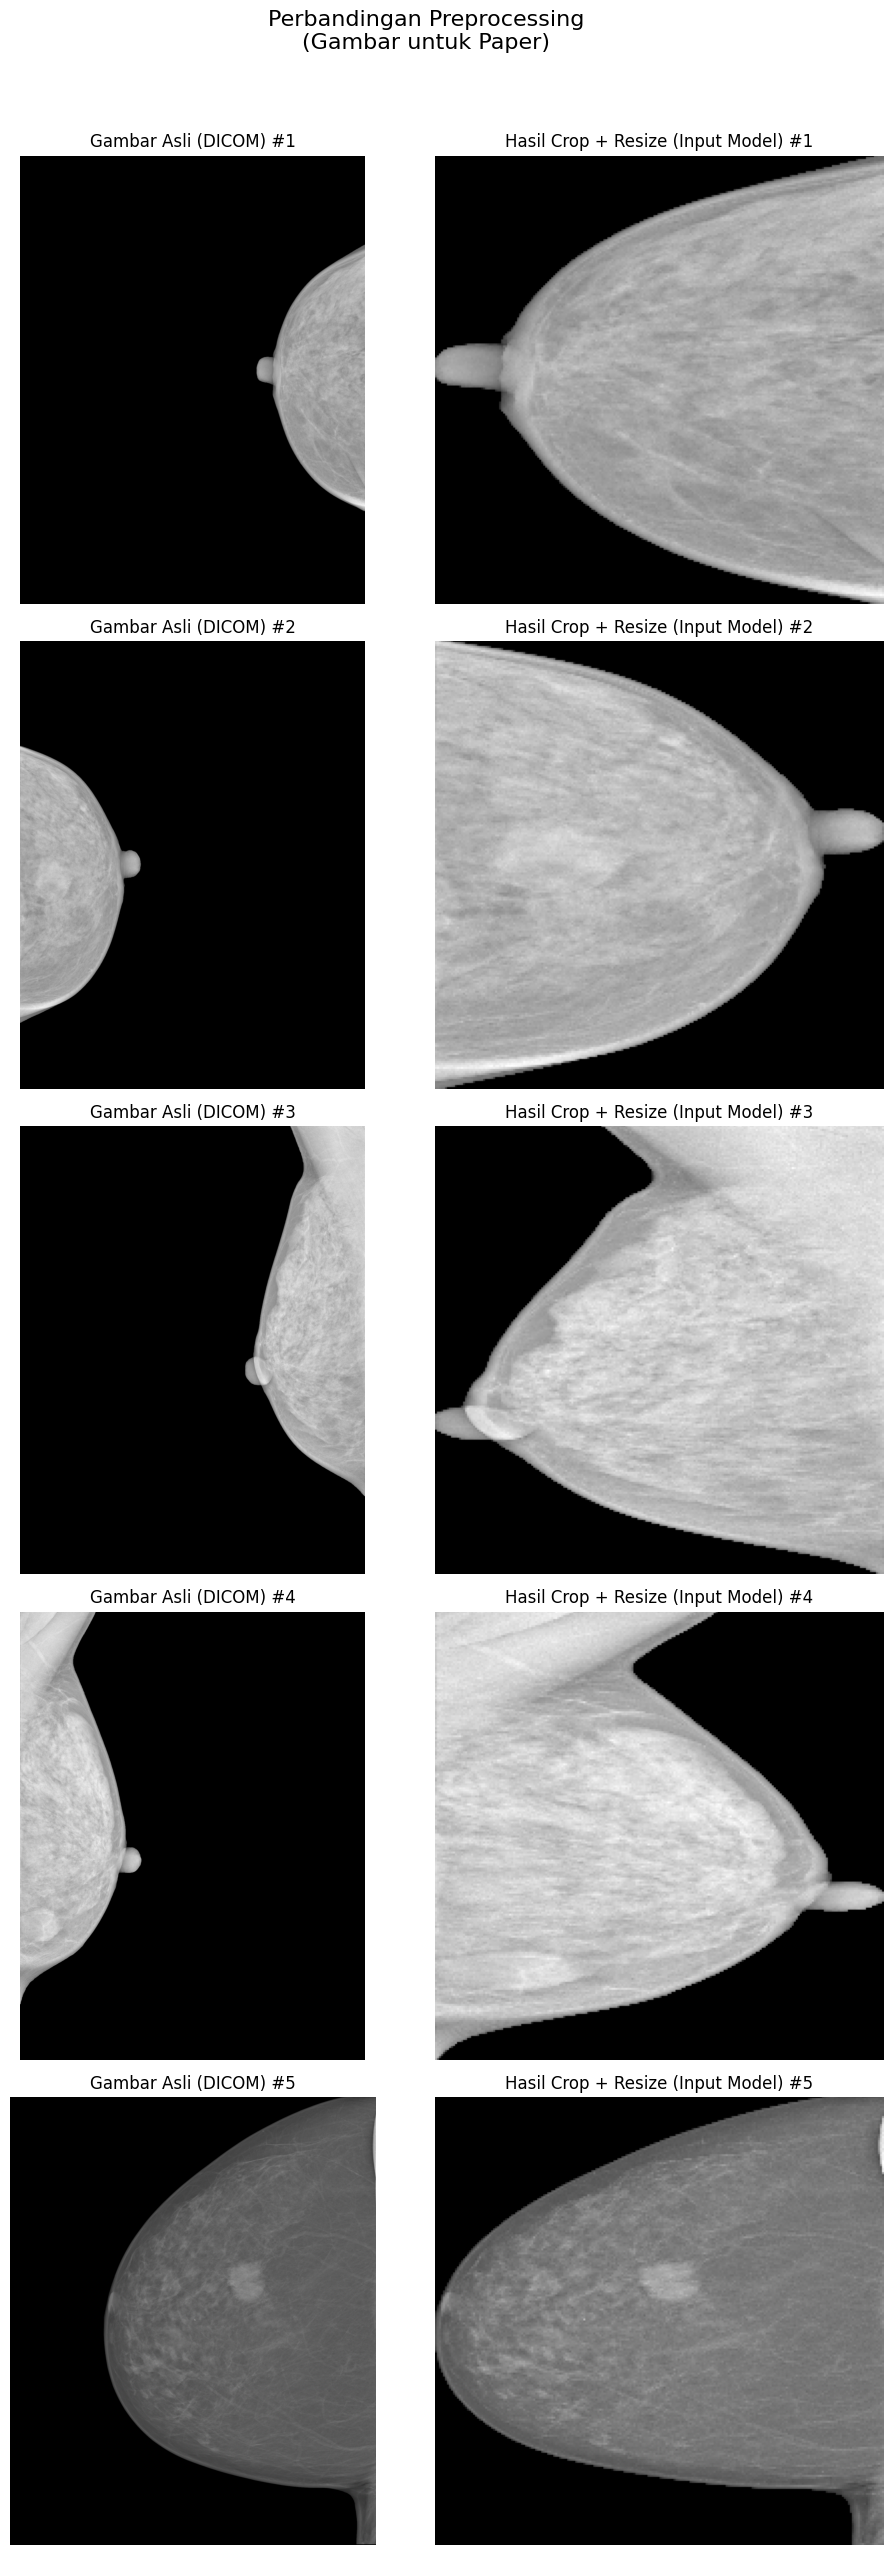

In [ ]:
print("Membuat gambar perbandingan 'Sebelum vs Sesudah'...")

num_images = len(original_images_for_viz)

# Pastikan num_images > 0 sebelum mencoba membuat plot
if num_images > 0:
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    fig.suptitle("Perbandingan Preprocessing\n(Gambar untuk Paper)", fontsize=16, y=1.02)

    for i in range(num_images):
        # --- Plot Gambar Asli (Kiri) ---
        ax_left = axes[i, 0]
        ax_left.imshow(original_images_for_viz[i], cmap='gray')
        ax_left.set_title(f"Gambar Asli (DICOM) #{i+1}")
        ax_left.axis('off')

        # --- Plot Gambar Hasil Proses (Kanan) ---
        ax_right = axes[i, 1]
        ax_right.imshow(cropped_images_for_viz[i], cmap='gray')
        ax_right.set_title(f"Hasil Crop + Resize (Input Model) #{i+1}")
        ax_right.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada gambar yang tersimpan untuk visualisasi.")

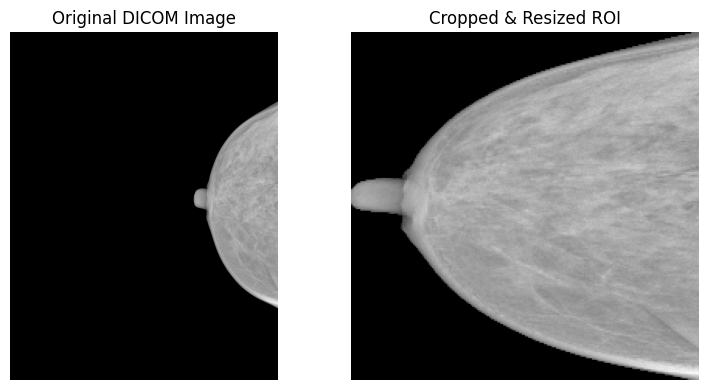

In [ ]:
import matplotlib.pyplot as plt

# Pastikan variabel original_images_for_viz sudah ada dari Blok 5
if len(original_images_for_viz) > 0:
    # Kita ambil index 0 (gambar pertama) sebagai contoh
    idx_to_show = 0

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    # Judul Utama (Opsional, bisa dihapus jika ingin pakai caption di Word saja)
    # fig.suptitle("Image Preprocessing Pipeline", fontsize=14)

    # --- Gambar Kiri (Asli) ---
    axes[0].imshow(original_images_for_viz[idx_to_show], cmap='gray')
    axes[0].set_title("Original DICOM Image", fontsize=12)
    axes[0].axis('off')

    # --- Gambar Kanan (Hasil Crop) ---
    axes[1].imshow(cropped_images_for_viz[idx_to_show], cmap='gray')
    axes[1].set_title("Cropped & Resized ROI", fontsize=12)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Data visualisasi tidak ditemukan. Jalankan Blok 5 terlebih dahulu.")

# arsitektur efficientnetv2

In [ ]:
# --- A. Fungsi `build_model` ---
def build_model():
    data_augmentation_layer = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ], name="data_augmentation")

    base_model = EfficientNetV2B0(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = Input(shape=INPUT_SHAPE, name="input_layer")
    x = data_augmentation_layer(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D(name="global_avg_pooling")(x)
    x = Dropout(0.5, name="dropout_layer")(x)
    outputs = Dense(2, activation='softmax', name="output_layer")(x)

    model = Model(inputs, outputs)

    return model, base_model

print("Fungsi build_model() telah didefinisikan.")


# --- B. Fungsi Pipeline Data Oversampling ---
def create_balanced_dataset(X_train_fold, y_train_fold_categorical):
    """
    Membuat tf.data.Dataset yang seimbang 50/50
    """
    # 1. Pisahkan data latih fold ini berdasarkan kelas
    y_train_fold_1d = np.argmax(y_train_fold_categorical, axis=1)

    X_train_benign = X_train_fold[y_train_fold_1d == 0]
    y_train_benign = y_train_fold_categorical[y_train_fold_1d == 0]

    X_train_malignant = X_train_fold[y_train_fold_1d == 1]
    y_train_malignant = y_train_fold_categorical[y_train_fold_1d == 1]

    # 2. Buat Dataset TensorFlow untuk setiap kelas
    benign_ds = tf.data.Dataset.from_tensor_slices((X_train_benign, y_train_benign))
    malignant_ds = tf.data.Dataset.from_tensor_slices((X_train_malignant, y_train_malignant))

    # 3. Buat pipeline
    benign_ds = benign_ds.shuffle(len(X_train_benign)).repeat()
    malignant_ds = malignant_ds.shuffle(len(X_train_malignant)).repeat()

    # 4. Gabungkan keduanya dengan rasio 50/50
    balanced_ds = tf.data.Dataset.zip((benign_ds, malignant_ds))
    balanced_ds = balanced_ds.map(lambda b, m: (tf.stack([b[0], m[0]]), tf.stack([b[1], m[1]])))
    balanced_ds = balanced_ds.unbatch()

    # 5. Siapkan untuk pelatihan
    BATCH_SIZE = 32
    train_ds = balanced_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Hitung steps_per_epoch
    steps_per_epoch = int(np.ceil(len(X_train_malignant) * 2 / BATCH_SIZE))

    return train_ds, steps_per_epoch

print("Fungsi create_balanced_dataset() telah didefinisikan.")

Fungsi build_model() telah didefinisikan.
Fungsi create_balanced_dataset() telah didefinisikan.


In [ ]:
N_SPLITS = 5
gkf = GroupKFold(n_splits=N_SPLITS)

all_true_labels = []
all_pred_labels = []
fold_accuracies = []
fold_recalls_ganas = []
fold_aucs = []

fold_no = 1

for train_index, test_index in gkf.split(X_data, y_labels, groups=groups):
    print(f"======================================================")
    print(f"========= MEMULAI FOLD KE-{fold_no} DARI {N_SPLITS} ==========")
    print(f"======================================================")

    # 1. Ambil data untuk fold ini
    X_train_fold, X_test_fold = X_data[train_index], X_data[test_index]
    y_train_fold_labels, y_test_fold_labels = y_labels[train_index], y_labels[test_index] # 1D labels
    y_train_fold_categorical = to_categorical(y_train_fold_labels, num_classes=2)
    y_test_fold_categorical = to_categorical(y_test_fold_labels, num_classes=2)

    print(f"Data Latih Fold Ini: {len(X_train_fold)} gambar")
    print(f"Data Uji Fold Ini: {len(X_test_fold)} gambar")

    # 2. Buat pipeline data latih yang seimbang
    train_ds, steps_per_epoch = create_balanced_dataset(X_train_fold, y_train_fold_categorical)

    # 3. Bangun model baru yang bersih
    model, base_model = build_model()

    # --- 4. (BARU) Langsung Unfreeze Model ---
    base_model.trainable = True
    FINE_TUNE_AT = -20
    for layer in base_model.layers[:FINE_TUNE_AT]:
        layer.trainable = False

    # --- 5. (BARU) Kompilasi Tunggal ---
    METRICS = [
        'accuracy',
        tf.keras.metrics.Recall(class_id=1, name='recall_ganas'),
        tf.keras.metrics.AUC(name='auc')
    ]

    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=METRICS
    )

    # Callback untuk Early Stopping
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='auc',
            mode='max',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
    ]

    # --- 6. (BARU) Pelatihan Tunggal ---
    print(f"\n--- Memulai Pelatihan Fine-Tuning Penuh (Fold {fold_no})... ---")
    TOTAL_EPOCHS = 100

    history = model.fit(
        train_ds,
        epochs=TOTAL_EPOCHS,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        verbose=1
    )

    # --- 7. Evaluasi Fold Ini ---
    print(f"\n--- Mengevaluasi Fold Ke-{fold_no} ---")

    scores = model.evaluate(X_test_fold, y_test_fold_categorical)

    print(f"Skor untuk Fold {fold_no}:")
    print(f"  Test Loss: {scores[0]:.4f}")
    print(f"  Test Accuracy: {scores[1]:.4f}")
    print(f"  Test Recall (Ganas): {scores[2]:.4f}")
    print(f"  Test AUC: {scores[3]:.4f}")

    fold_accuracies.append(scores[1])
    fold_recalls_ganas.append(scores[2])
    fold_aucs.append(scores[3])

    y_pred_probs = model.predict(X_test_fold)
    y_pred_fold_labels = np.argmax(y_pred_probs, axis=1)

    all_true_labels.extend(y_test_fold_labels)
    all_pred_labels.extend(y_pred_fold_labels)

    fold_no += 1

========= MEMULAI FOLD KE-1 DARI 5 ==========
Data Latih Fold Ini: 327 gambar
Data Uji Fold Ini: 83 gambar
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Memulai Pelatihan Fine-Tuning Penuh (Fold 1)... ---
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4672 - auc: 0.4517 - loss: 0.7554 - recall_ganas: 0.5223
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4704 - auc: 0.4593 - loss: 0.7632 - recall_ganas: 0.5148
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5667 - auc: 0.5517 - loss: 0.7277 - recall_ganas: 0.6039
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4892 - auc: 0.5013 - loss: 0.7501 - recall_ganas: 0.6035
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5004 - auc: 0.5271 - loss: 0.7215 - recall_ganas: 0.5493
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.5755 - auc: 0.5967 - loss: 0.6798 - recall_ganas: 0.5972
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.56

2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
========= MEMULAI FOLD KE-4 DARI 5 ==========
Data Latih Fold Ini: 328 gambar
Data Uji Fold Ini: 82 gambar

--- Memulai Pelatihan Fine-Tuning Penuh (Fold 4)... ---
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3995 - auc: 0.4205 - loss: 0.7807 - recall_ganas: 0.3509
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5388 - auc: 0.5158 - loss: 0.7080 - recall_ganas: 0.4471
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5141 - auc: 0.5057 - loss: 0.7177 - recall_ganas: 0.4800
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4632 - auc: 0.4532 - loss: 0.8023 - recall_ganas: 0.4087
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5208 - auc: 0.5215 - loss: 0.7071 - recall_ganas: 0.4614
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4692 - auc: 0.4620 - loss: 0.7461 - recall_ganas: 0.4282
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5128 - auc: 0.54


===== HASIL AKHIR GABUNGAN (SEMUA FOLDS) =====
Hasil Skor dari 5 Folds:
  - Fold 1: Acc: 0.3133 | Recall (Ganas): 1.0000 | AUC: 0.2749
  - Fold 2: Acc: 0.7561 | Recall (Ganas): 0.0000 | AUC: 0.7769
  - Fold 3: Acc: 0.7778 | Recall (Ganas): 0.0000 | AUC: 0.8189
  - Fold 4: Acc: 0.2439 | Recall (Ganas): 1.0000 | AUC: 0.2237
  - Fold 5: Acc: 0.8049 | Recall (Ganas): 0.0000 | AUC: 0.8049

--- Rata-Rata Metrik Kinerja ---
AKURASI RATA-RATA: 0.5792
RECALL (GANAS) RATA-RATA: 0.4000
AUC RATA-RATA: 0.5799

Classification Report (Gabungan):
              precision    recall  f1-score   support

   Jinak (0)       0.78      0.62      0.69       310
   Ganas (1)       0.28      0.46      0.35       100

    accuracy                           0.58       410
   macro avg       0.53      0.54      0.52       410
weighted avg       0.66      0.58      0.61       410

Confusion Matrix (Gabungan):


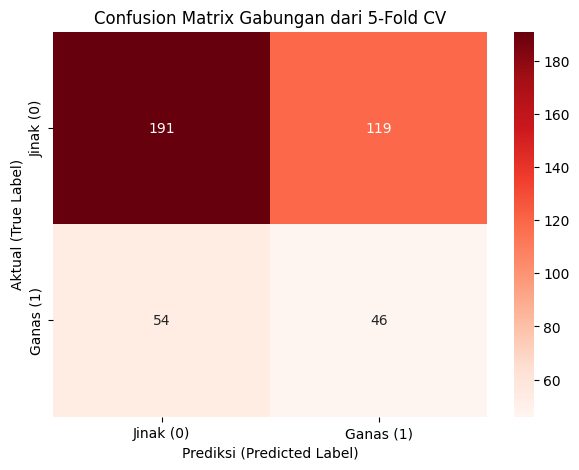

In [ ]:
print(f"\n======================================================")
print(f"===== HASIL AKHIR GABUNGAN (SEMUA FOLDS) =====")
print(f"======================================================")

# --- 1. Tampilkan Rata-rata Skor ---
print(f"Hasil Skor dari {N_SPLITS} Folds:")
for i in range(N_SPLITS):
    if i < len(fold_accuracies):
        print(f"  - Fold {i+1}: Acc: {fold_accuracies[i]:.4f} | Recall (Ganas): {fold_recalls_ganas[i]:.4f} | AUC: {fold_aucs[i]:.4f}")

print("\n--- Rata-Rata Metrik Kinerja ---")
print(f"AKURASI RATA-RATA: {np.mean(fold_accuracies):.4f}")
print(f"RECALL (GANAS) RATA-RATA: {np.mean(fold_recalls_ganas):.4f}")
print(f"AUC RATA-RATA: {np.mean(fold_aucs):.4f}")

# --- 2. Tampilkan Classification Report ---
print("\nClassification Report (Gabungan):")
class_names = ['Jinak (0)', 'Ganas (1)']
print(classification_report(all_true_labels, all_pred_labels, target_names=class_names, labels=[0, 1], zero_division=0))

# --- 3. Tampilkan Confusion Matrix ---
print("Confusion Matrix (Gabungan):")
confusion_mtx = confusion_matrix(all_true_labels, all_pred_labels, labels=[0, 1])

plt.figure(figsize=(7, 5))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Gabungan dari 5-Fold CV')
plt.ylabel('Aktual (True Label)')
plt.xlabel('Prediksi (Predicted Label)')
plt.show()

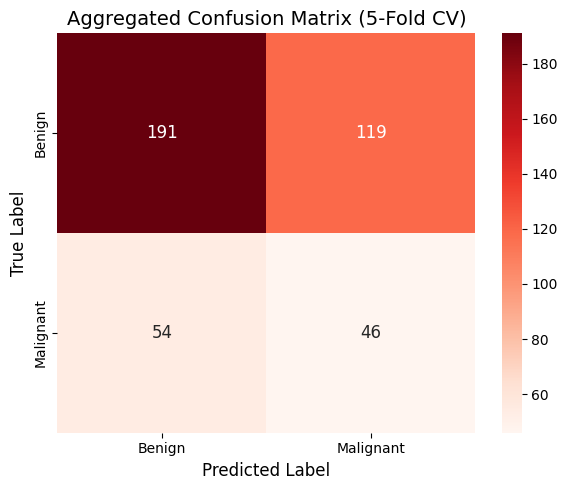

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Pastikan Blok 8 (Evaluasi) sudah dijalankan sehingga all_true_labels terisi
if 'all_true_labels' in locals() and len(all_true_labels) > 0:
    # Hitung Confusion Matrix
    cm = confusion_matrix(all_true_labels, all_pred_labels)

    plt.figure(figsize=(6, 5))

    # Membuat Heatmap dengan label bahasa Inggris
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'],
                annot_kws={"size": 12})

    plt.title('Aggregated Confusion Matrix (5-Fold CV)', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    plt.tight_layout()
    plt.show()
else:
    print("Data hasil evaluasi tidak ditemukan. Jalankan Blok 7/8 terlebih dahulu.")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


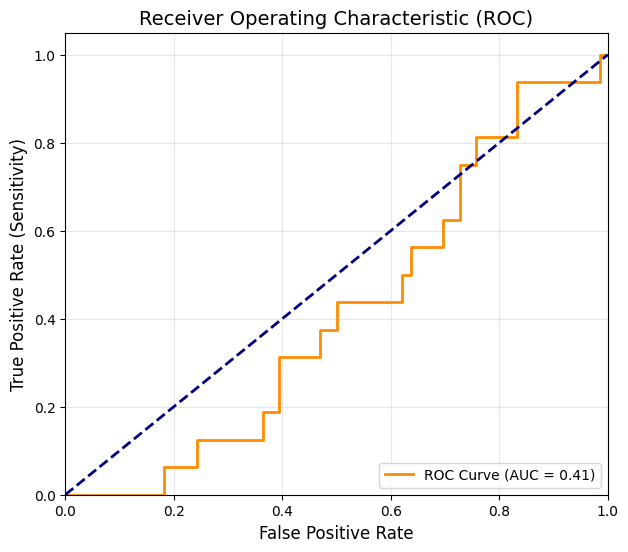

In [ ]:
from sklearn.metrics import roc_curve, auc

# Kita gunakan model dan data test dari fold terakhir yang masih ada di memori
if 'model' in locals() and 'X_test_fold' in locals():

    # Dapatkan probabilitas prediksi
    y_pred_probs = model.predict(X_test_fold)
    y_test_indices = np.argmax(y_test_fold_categorical, axis=1)

    # Hitung FPR, TPR, dan AUC untuk kelas 'Malignant' (index 1)
    fpr, tpr, _ = roc_curve(y_test_indices, y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))

    # Plot Kurva
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Garis random guess

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.show()
else:
    print("Model/Data fold terakhir tidak ditemukan. Jalankan Blok 7 terlebih dahulu.")

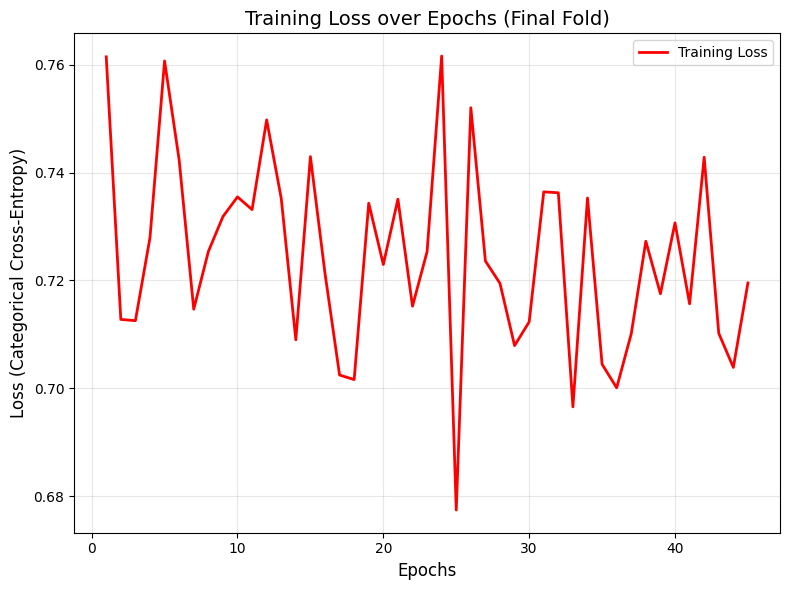

In [ ]:
import matplotlib.pyplot as plt

# Pastikan variabel 'history' tersedia dari Blok 7 (hasil training fold terakhir)
if 'history' in locals():
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 6))

    # Plot Loss
    plt.plot(epochs, loss, label='Training Loss', color='red', linewidth=2)

    # Judul dan Label dalam Bahasa Inggris
    plt.title('Training Loss over Epochs (Final Fold)', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss (Categorical Cross-Entropy)', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Data history tidak ditemukan. Pastikan Anda sudah menjalankan Blok 7 (Pelatihan) sampai selesai.")

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1116']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


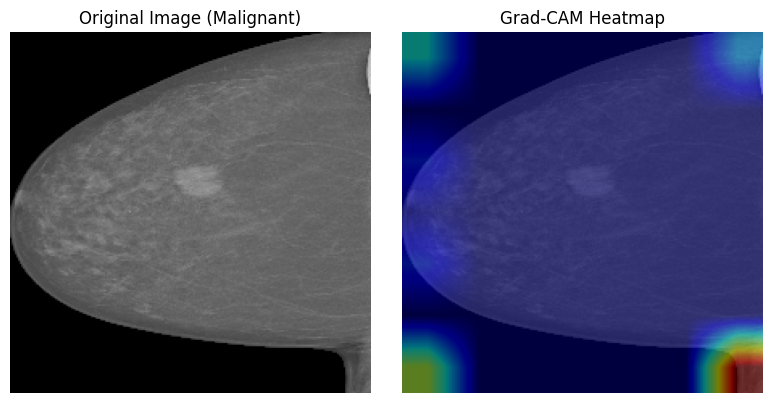

In [ ]:
# --- Pastikan fungsi make_gradcam_heatmap sudah didefinisikan ---
# (Jika belum, copy-paste fungsi dari respon saya sebelumnya di sini)

# Cari gambar Malignant di fold terakhir
malignant_indices = np.where(np.argmax(y_test_fold_categorical, axis=1) == 1)[0]

if len(malignant_indices) > 0:
    idx = malignant_indices[0] # Ambil contoh pertama
    img = X_test_fold[idx]
    img_array = np.expand_dims(img, axis=0)

    # Setup Model Grad-CAM (untuk EfficientNetV2B0 layer 'top_activation')
    # Catatan: Ini perlu disesuaikan jika nama layer berbeda, tapi biasanya 'top_activation'
    try:
        # Akses layer internal
        eff_layer = model.get_layer('efficientnetv2-b0')
        last_conv_layer_name = 'top_activation'
        grad_model = tf.keras.models.Model(
            [eff_layer.inputs],
            [eff_layer.get_layer(last_conv_layer_name).output, eff_layer.output]
        )

        # Hitung Gradien
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            class_channel = preds[:, 1] # Kelas Malignant

        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmap = heatmap.numpy()

        # Plotting
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title("Original Image (Malignant)", fontsize=12)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img, cmap='gray')
        plt.imshow(cv2.resize(heatmap, (224, 224)), cmap='jet', alpha=0.5)
        plt.title("Grad-CAM Heatmap", fontsize=12)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Gagal membuat Grad-CAM: {e}")
else:
    print("Tidak ada sampel Malignant di fold test terakhir.")